In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [134]:
dhs = pd.read_stata('SNIR8BFL.DTA', convert_categoricals = False) # Need raw .dta DHS data file here. Using Senegal DHS 2019.
model = pd.read_csv('parity_methods_model.csv', index_col = 0)  # Substitute csv here from running 'examine_parity.py'

# To truncate parity at 7+
parity_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:7, 9:7, 10:7, 11:7, 12:7, 13:7}
dhs['v201'] = dhs['v201'].map(parity_dict)
model['parity'] = model['parity'].map(parity_dict)

In [135]:
def parity_mcpr(data, name, parity, method, weight):
        total = data.groupby(parity)[weight].sum()
        parity_group = data.groupby([parity, method])[weight].sum()
        if data is dhs:
            n = total/1000000
        else:
            n = total
        totals = n
        parity_group = 100 * parity_group.divide(total).fillna(0)
        parity_group.name = 'Percent'
        return parity_group, totals

In [136]:
# Calculate total mCPR in DHS data to check matches STAT Complier.  Target is 17.9%.
method_group = dhs.groupby(['v313'])['v005'].sum()
total = dhs['v005'].sum()
method_group = 100 * method_group.divide(total).fillna(0)
method_group.name = 'Percent'
method_group

v313
0    81.168383
1     0.500119
2     0.428890
3    17.902607
Name: Percent, dtype: float64

In [137]:
# Recategorize methods on model data.  
'''
Key to method type, from model.
Method mix in DHS 2017 data informing contraceptive choice matrix parameters in model:
Other: other traditional(0.5%), EC(0.015%), LAM (0.047%), other modern (0.008%)
Rhythm: periodic abstinence (0.39%), SDM(0.06%)
Withdrawal: 0.12%
Other, rhythm, and withdrawal from model categorized as traditional for this analysis,
    though 0.07% (EC, LAM, other modern) are technically modern in comparative DHS data.
methods_model_dict = {
    'None': 0,
    'Pill': 1,
    'IUDs': 2,
    'Injectables': 3,
    'Condoms': 4,
    'BTL': 5,
    'Rhythm': 6,
    'Withdrawal': 7,
    'Implants': 8,
    'Other': 9,
    }
'''
method_dict = {0:0, 1:3, 2:3, 3:3, 4:3, 5:3,  6:2, 7:2, 8:3, 9:2}
model['method'] = model['method'].map(method_dict)
model['wgt'] = 1 # Add weighting to model data (all 1)

In [138]:
# Calculate total mCPR in FPSim to compare to DHS data
method_group_model = model.groupby(['method'])['wgt'].sum()
total = model['wgt'].sum()
method_group_model = 100 * method_group_model.divide(total).fillna(0)
method_group_model.name = 'Percent'
method_group_model

method
0    82.927147
2     1.329337
3    15.743516
Name: Percent, dtype: float64

In [139]:
#Find percentages of none (0), folkloric (1), traditional (2), and modern (3) contraception use across parity groups 
table_dhs, totals = parity_mcpr(data = dhs, name = 'percent', parity ='v201', method = 'v313', weight = 'v005')
table_dhs

v201  v313
0     0       98.991499
      2        0.138670
      3        0.869831
1     0       77.316992
      1        0.448391
      2        0.555576
      3       21.679042
2     0       73.192872
      1        0.250800
      2        0.650296
      3       25.906032
3     0       70.683045
      1        0.611751
      2        1.305233
      3       27.399970
4     0       65.732636
      1        0.417814
      2        0.324882
      3       33.524668
5     0       68.495289
      1        0.965407
      2        0.516142
      3       30.023162
6     0       66.153548
      1        2.008183
      2        0.190512
      3       31.647758
7     0       67.193848
      1        1.711823
      2        0.409041
      3       30.685288
Name: Percent, dtype: float64

In [140]:
table_model, totals_model = parity_mcpr(data = model, name = 'percent', parity ='parity', method = 'method', weight = 'wgt')
table_model

parity  method
0.0     0         94.313910
        2          0.422932
        3          5.263158
1.0     0         84.567901
        2          1.058201
        3         14.373898
2.0     0         80.897704
        2          1.670146
        3         17.432150
3.0     0         79.016787
        2          1.798561
        3         19.184652
4.0     0         75.415282
        2          1.661130
        3         22.923588
5.0     0         74.218750
        2          1.953125
        3         23.828125
6.0     0         73.479319
        2          2.189781
        3         24.330900
7.0     0         75.549451
        2          1.923077
        3         22.527473
Name: Percent, dtype: float64

In [141]:
# Create DataFrames and select out only modern or traditional contraception

parity_df_mod_dhs = pd.DataFrame(table_dhs).copy(deep=True)
parity_df_trad_dhs = pd.DataFrame(table_dhs).copy(deep=True)
parity_df_mod_model = pd.DataFrame(table_model).copy(deep = True)
parity_df_trad_model = pd.DataFrame(table_model).copy(deep = True)

def process_mcpr(data, method):
    data.reset_index(inplace = True)
    modern = data[data[method]==3]
    modern.reset_index(drop=True, inplace=True)
    return modern

def process_tcpr(data, method):
    data.reset_index(inplace = True)
    trad = data[data[method]==2]
    trad.reset_index(drop=True, inplace=True)
    return trad

parity_modern_dhs = process_mcpr(parity_df_mod_dhs, method = 'v313')
parity_trad_dhs = process_tcpr(parity_df_trad_dhs, method = 'v313')
parity_modern_model = process_mcpr(parity_df_mod_model, method = 'method')
parity_trad_model = process_tcpr(parity_df_trad_model, method = 'method')

In [142]:
parity_modern_dhs

,v201,v313,Percent
0,0,3,0.869831
1,1,3,21.679042
2,2,3,25.906032
3,3,3,27.399970
4,4,3,33.524668
5,5,3,30.023162
6,6,3,31.647758
7,7,3,30.685288


In [143]:
parity_modern_model

,parity,method,Percent
0,0.0,3,5.263158
1,1.0,3,14.373898
2,2.0,3,17.432150
3,3.0,3,19.184652
4,4.0,3,22.923588
5,5.0,3,23.828125
6,6.0,3,24.330900
7,7.0,3,22.527473


In [144]:
# Find sameple size in each group, totals returned from function parity_mcpr() above
parity_modern_model['totals'] = totals_model
overall_model = parity_modern_model['totals'].sum()
overall_percent_model = (parity_modern_model['totals']/overall_model)*100
parity_modern_model['parity percent'] = overall_percent_model
parity_modern_model['model'] = 1
parity_modern_model = parity_modern_model.rename(columns = {'Percent': 'mcpr'})
parity_modern_model

/Users/Annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,parity,method,mcpr,totals,parity percent,model
0,0.0,3,5.263158,2128,27.740842,1
1,1.0,3,14.373898,1134,14.782949,1
2,2.0,3,17.432150,958,12.488593,1
3,3.0,3,19.184652,834,10.872116,1
4,4.0,3,22.923588,602,7.847738,1
5,5.0,3,23.828125,512,6.674488,1
6,6.0,3,24.330900,411,5.357841,1
7,7.0,3,22.527473,1092,14.235432,1


In [145]:
parity_modern_dhs['totals'] = totals
overall = parity_modern_dhs['totals'].sum()
overall_percent = (parity_modern_dhs['totals']/overall)*100
parity_modern_dhs['parity percent'] = overall_percent
parity_modern_dhs['model'] = 0
parity_modern_dhs = parity_modern_dhs.rename(columns = {'v201':'parity', 'v313': 'method','Percent': 'mcpr'})
parity_modern_dhs

/Users/Annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Annie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,parity,method,mcpr,totals,parity percent,model
0,0,3,0.869831,3170.519152,36.657640,0
1,1,3,21.679042,1198.568166,13.857882,0
2,2,3,25.906032,990.637330,11.453779,0
3,3,3,27.399970,797.838021,9.224628,0
4,4,3,33.524668,722.942245,8.358680,0
5,5,3,30.023162,552.181954,6.384345,0
6,6,3,31.647758,453.252566,5.240520,0
7,7,3,30.685288,763.060258,8.822526,0


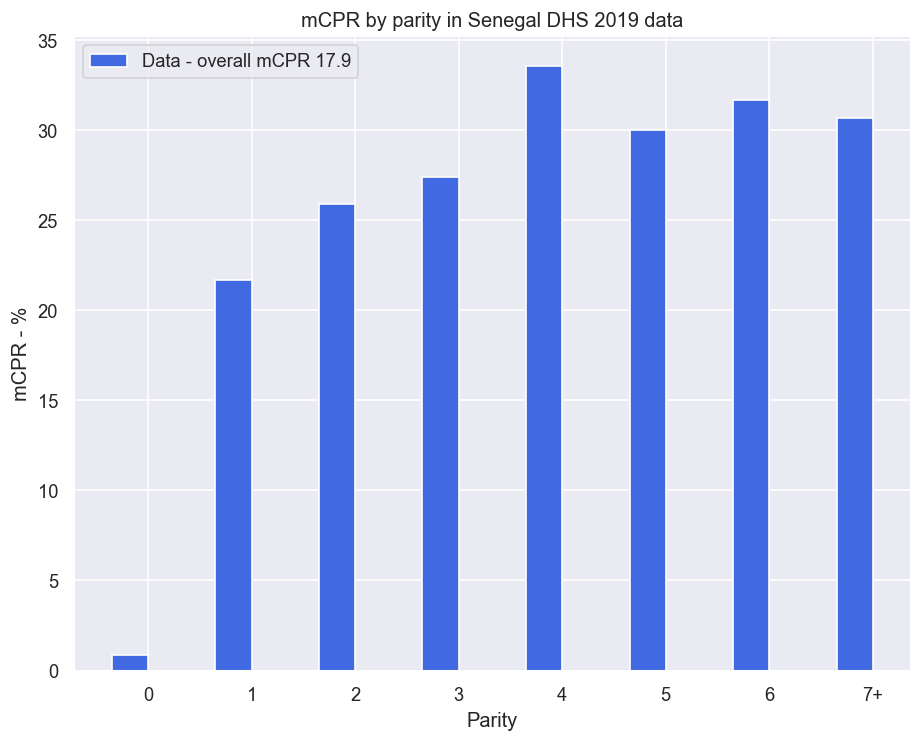

In [146]:
mCPR_dhs = parity_modern_dhs['mcpr']
mCPR_model = parity_modern_model['mcpr']

ind = parity_modern_dhs['parity']
width = 0.35

fig = plt.figure(figsize=(9, 7), dpi=120)
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, mCPR_dhs, width, color='royalblue', label = 'Data - overall mCPR 17.9')

#rects2 = ax.bar(ind+width, mCPR_model, width, color='orange')

ax.set_ylabel('mCPR - %')
ax.set_xlabel('Parity')
ax.set_title('mCPR by parity in Senegal DHS 2019 data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('0', '1', '2', '3', '4', '5', '6', '7+')) 

ax.legend(loc = 'upper left')

plt.show()

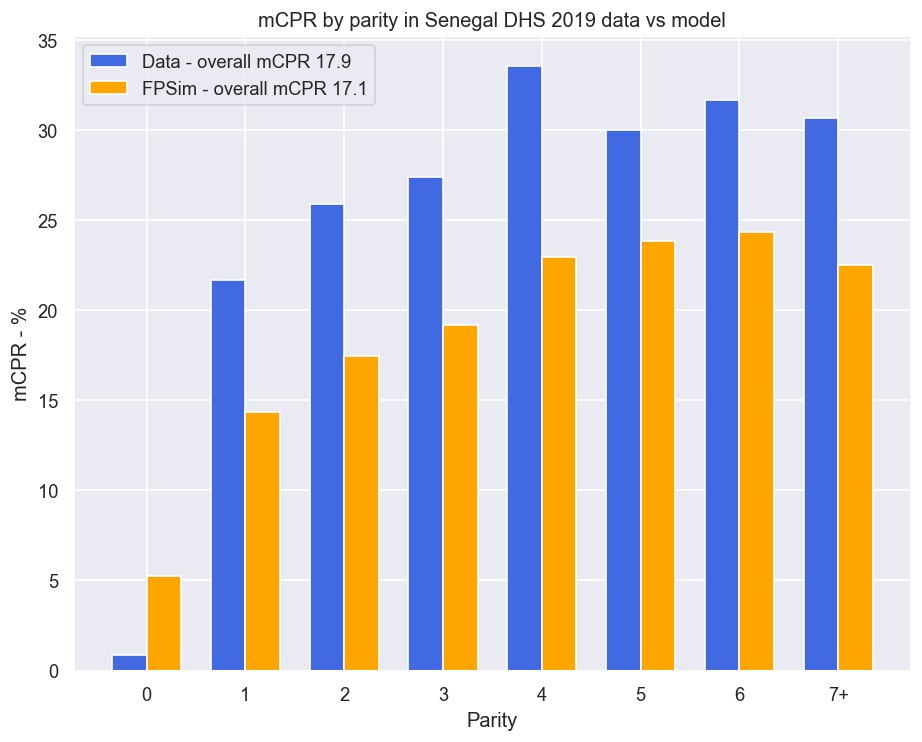

In [147]:
mCPR_dhs = parity_modern_dhs['mcpr']
mCPR_model = parity_modern_model['mcpr']

ind = parity_modern_dhs['parity']
width = 0.35

fig = plt.figure(figsize=(9, 7), dpi=120)
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, mCPR_dhs, width, color='royalblue')

rects2 = ax.bar(ind+width, mCPR_model, width, color='orange')

ax.set_ylabel('mCPR - %')
ax.set_xlabel('Parity')
ax.set_title('mCPR by parity in Senegal DHS 2019 data vs model')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('0', '1', '2', '3', '4', '5', '6', '7+')) 

ax.legend( (rects1[0], rects2[0]), ('Data - overall mCPR 17.9', 'FPSim - overall mCPR 17.1'), loc = 'upper left')

plt.show()

In [148]:
dhs_vs_model = parity_modern_dhs.append(parity_modern_model)
dhs_vs_model

,parity,method,mcpr,totals,parity percent,model
0,0.0,3,0.869831,3170.519152,36.657640,0
1,1.0,3,21.679042,1198.568166,13.857882,0
2,2.0,3,25.906032,990.637330,11.453779,0
3,3.0,3,27.399970,797.838021,9.224628,0
4,4.0,3,33.524668,722.942245,8.358680,0
5,5.0,3,30.023162,552.181954,6.384345,0
6,6.0,3,31.647758,453.252566,5.240520,0
7,7.0,3,30.685288,763.060258,8.822526,0
0,0.0,3,5.263158,2128.000000,27.740842,1
1,1.0,3,14.373898,1134.000000,14.782949,1


In [149]:
source_dict = {0:'DHS - overall mCPR 17.9', 1:'FPSim - overall mCPR 17.1'}
dhs_vs_model['model'] = dhs_vs_model['model'].map(source_dict)
dhs_vs_model

,parity,method,mcpr,totals,parity percent,model
0,0.0,3,0.869831,3170.519152,36.657640,DHS - overall mCPR 17.9
1,1.0,3,21.679042,1198.568166,13.857882,DHS - overall mCPR 17.9
2,2.0,3,25.906032,990.637330,11.453779,DHS - overall mCPR 17.9
3,3.0,3,27.399970,797.838021,9.224628,DHS - overall mCPR 17.9
4,4.0,3,33.524668,722.942245,8.358680,DHS - overall mCPR 17.9
5,5.0,3,30.023162,552.181954,6.384345,DHS - overall mCPR 17.9
6,6.0,3,31.647758,453.252566,5.240520,DHS - overall mCPR 17.9
7,7.0,3,30.685288,763.060258,8.822526,DHS - overall mCPR 17.9
0,0.0,3,5.263158,2128.000000,27.740842,FPSim - overall mCPR 17.1
1,1.0,3,14.373898,1134.000000,14.782949,FPSim - overall mCPR 17.1


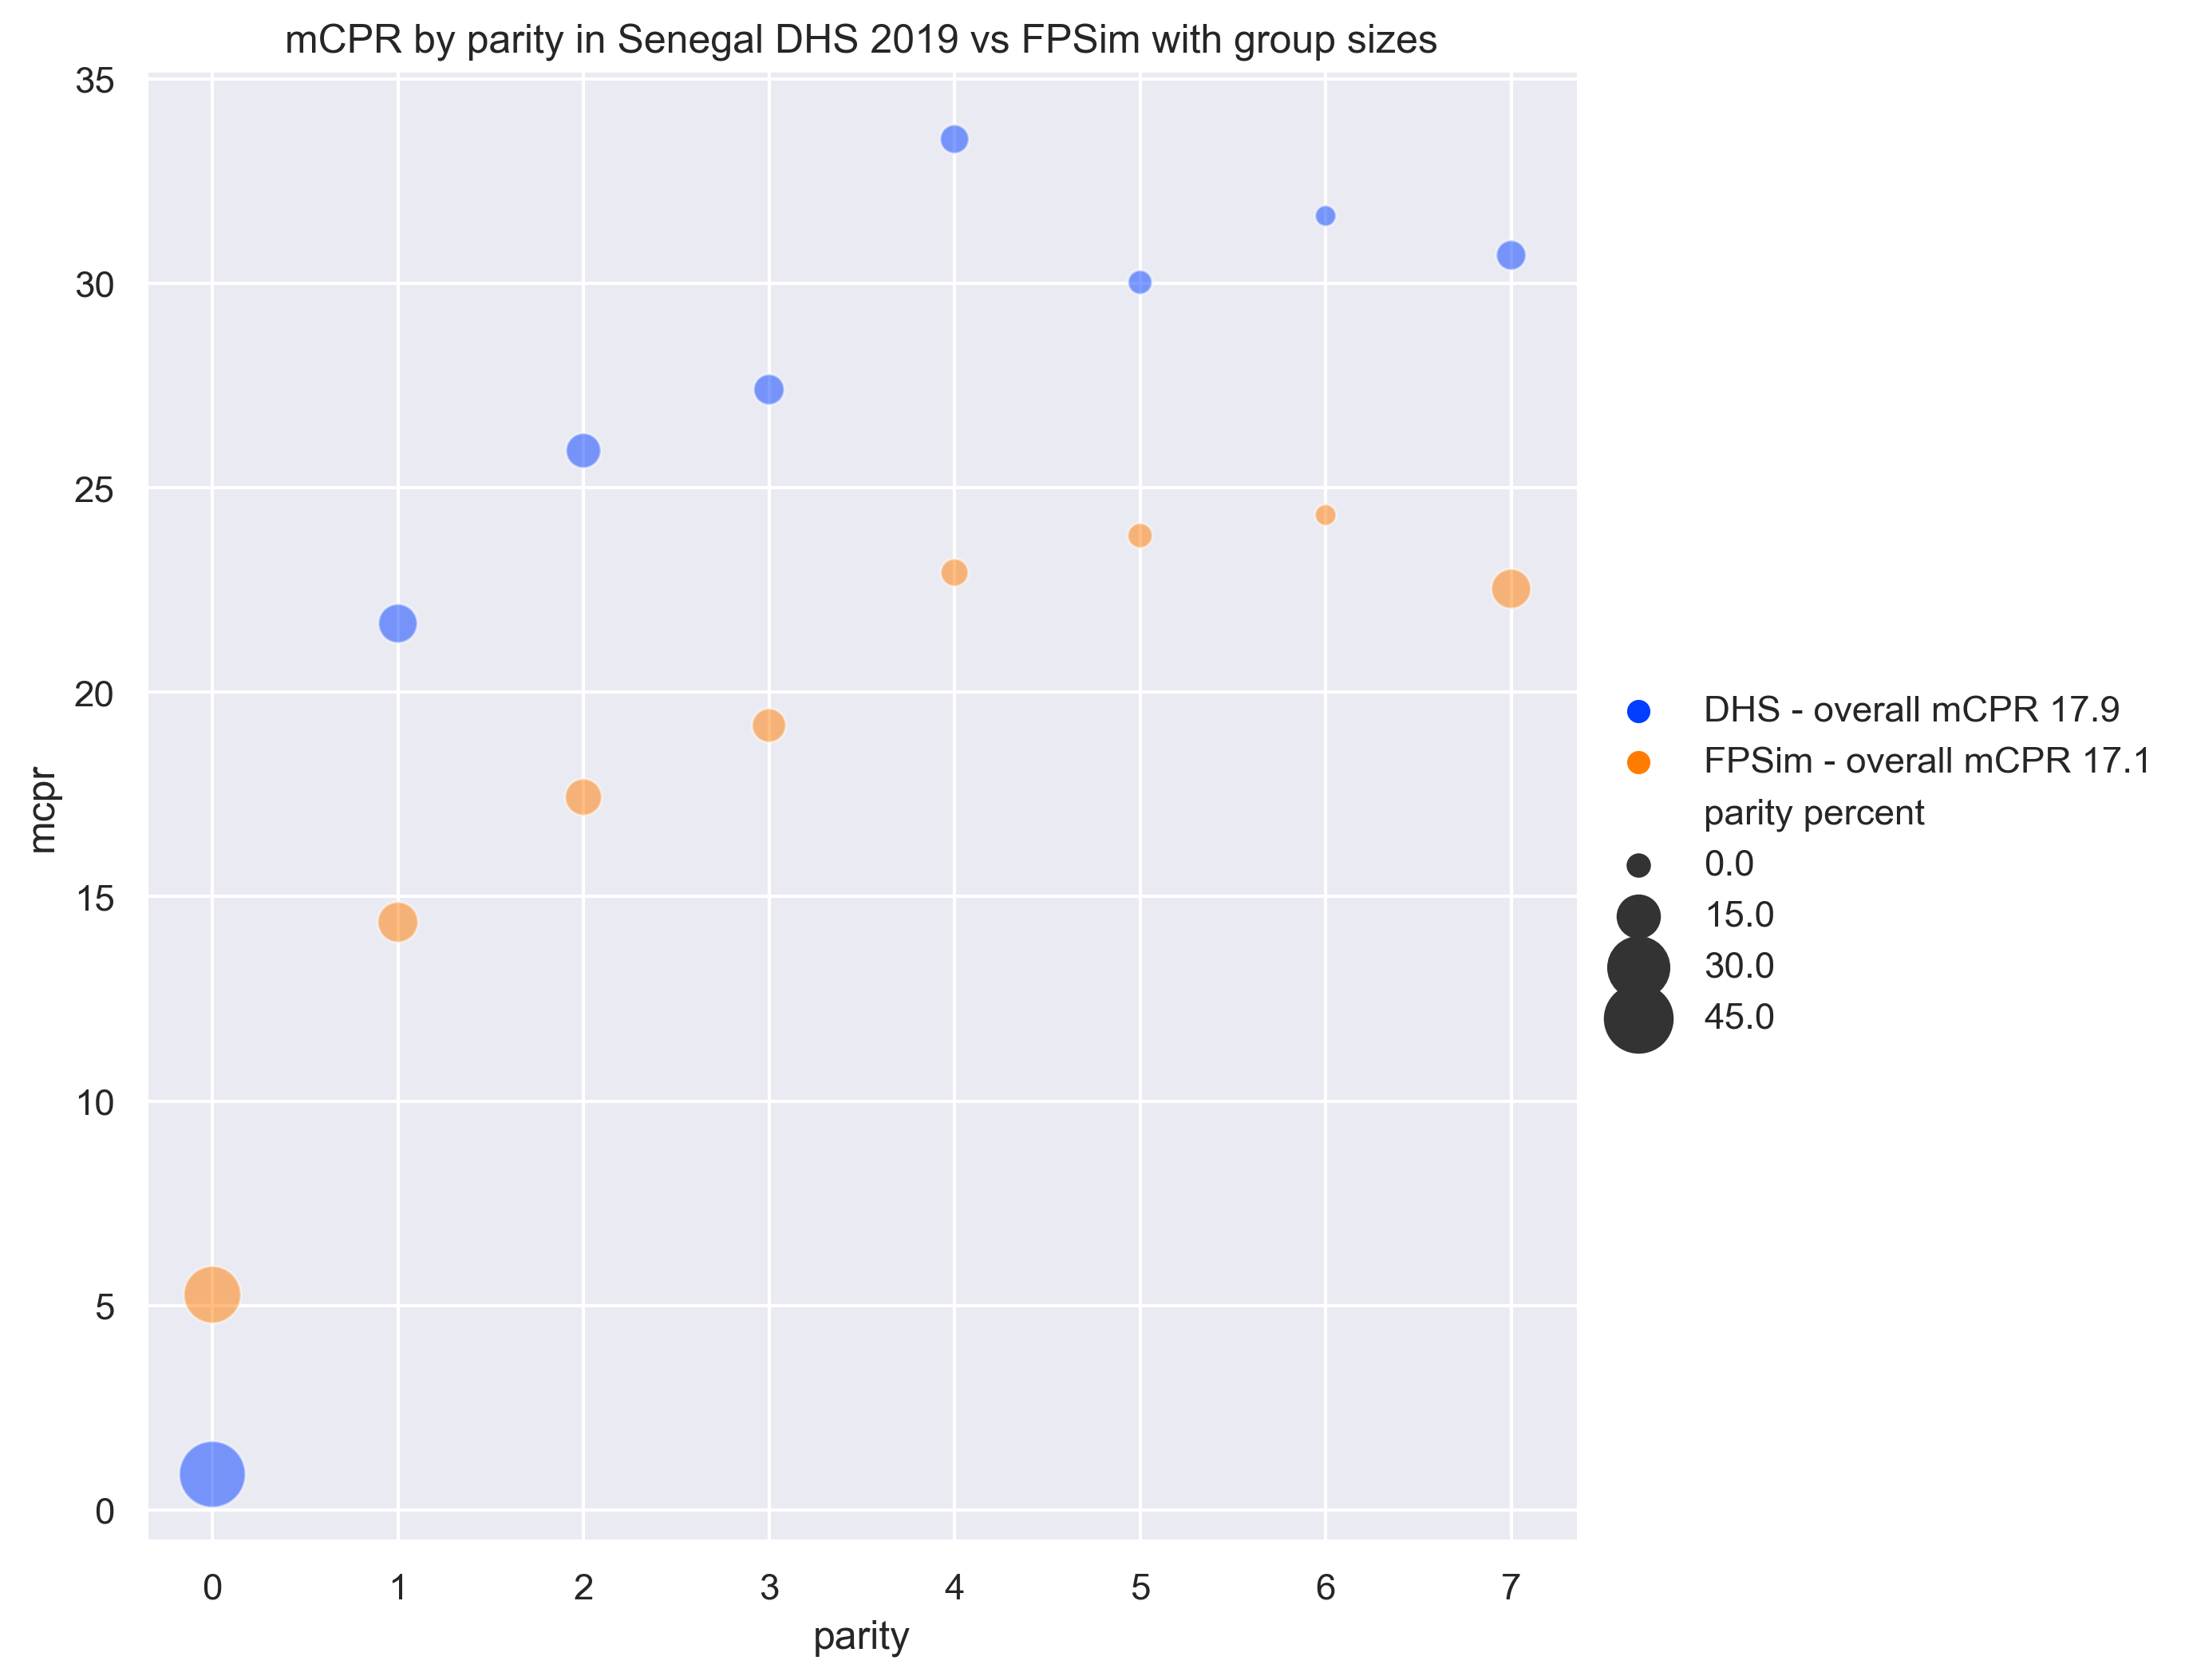

In [150]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
g = sns.relplot(x="parity", y="mcpr", hue = 'model', size="parity percent",
            sizes=(40, 400), alpha=.5, palette="bright",
            height=7, aspect=1, data=dhs_vs_model)
g._legend.texts[0].set_text("")
g.set(title = 'mCPR by parity in Senegal DHS 2019 vs FPSim with group sizes')